# Подготовка данных для определения параметров модели, предсказывающей результаты госэкзамена по математике для каждого ученика в зависимости от условий жизни обучающихся

Импорт необходимых библиотек:

In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
import plotly.figure_factory as ff
from itertools import combinations
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

init_notebook_mode(connected=True)
cf.go_offline()

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

### Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

    Проведем разведывательный анализ данных и определим параметры, влияющие на успеваемость, то есть на количество баллов по госэкзамену по математике 'score'

# I. Первичный отсмотр данных

In [2]:
df = pd.read_csv('stud_math.csv')
display(df.head(10))
df.info()

school sex  age address famsize Pstatus  Medu  Fedu      Mjob     Fjob  \
0     GP   F   18       U     NaN       A   4.0   4.0   at_home  teacher   
1     GP   F   17       U     GT3     NaN   1.0   1.0   at_home    other   
2     GP   F   15       U     LE3       T   1.0   1.0   at_home    other   
3     GP   F   15       U     GT3       T   4.0   2.0    health      NaN   
4     GP   F   16       U     GT3       T   3.0   3.0     other    other   
5     GP   M   16       U     LE3       T   4.0   3.0  services    other   
6     GP   M   16     NaN     LE3       T   2.0   2.0     other    other   
7     GP   F   17       U     GT3       A   4.0   4.0     other  teacher   
8     GP   M   15       U     LE3       A   3.0   2.0  services    other   
9     GP   M   15       U     NaN     NaN   3.0   4.0     other    other   

       reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0      course   mother         2.0        2.0       0.0       yes     no   no   
1      course   father         1.0        2.0       0.0        no    yes   no   
2       other   mother         1.0        2.0       3.0       yes     no  NaN   
3        home   mother         1.0        3.0       0.0        no    yes  yes   
4        home   father         1.0        2.0       0.0        no    yes  yes   
5  reputation   mother         1.0        2.0       0.0        no    yes  yes   
6        home   mother         1.0        2.0       0.0        no     no   no   
7        home   mother         2.0        2.0       0.0       yes    yes   no   
8        home   mother         1.0        2.0       0.0        no    yes  yes   
9        home   mother         1.0        2.0       0.0        no    yes  yes   

  activities nursery  studytime, granular higher internet romantic  famrel  \
0         no     yes                 -6.0    yes      NaN       no     4.0   
1         no      no                 -6.0    yes      yes       no     5.0   
2         no     yes                 -6.0    yes      yes      NaN     4.0   
3        yes     yes                 -9.0    yes      yes      yes     3.0   
4         no     yes                 -6.0    yes       no       no     4.0   
5        yes     yes                 -6.0    yes      yes       no     5.0   
6         no     yes                 -6.0    yes      yes       no     4.0   
7         no     yes                 -6.0    yes       no       no     4.0   
8         no     yes                 -6.0    yes      yes       no     NaN   
9        yes     yes                 -6.0    yes      yes       no     5.0   

   freetime  goout  health  absences  score  
0       3.0    4.0     3.0       6.0   30.0  
1       3.0    3.0     3.0       4.0   30.0  
2       3.0    2.0     3.0      10.0   50.0  
3       2.0    2.0     5.0       2.0   75.0  
4       3.0    2.0     5.0       4.0   50.0  
5       4.0    2.0     5.0      10.0   75.0  
6       4.0    4.0     3.0       0.0   55.0  
7       1.0    4.0     1.0       6.0   30.0  
8       2.0    2.0     1.0       0.0   95.0  
9       5.0    1.0     5.0       0.0   75.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [3]:
df.describe(include='all')

school  sex         age address famsize Pstatus        Medu  \
count     395  395  395.000000     378     368     350  392.000000   
unique      2    2         NaN       2       2       2         NaN   
top        GP    F         NaN       U     GT3       T         NaN   
freq      349  208         NaN     295     261     314         NaN   
mean      NaN  NaN   16.696203     NaN     NaN     NaN    2.750000   
std       NaN  NaN    1.276043     NaN     NaN     NaN    1.098127   
min       NaN  NaN   15.000000     NaN     NaN     NaN    0.000000   
25%       NaN  NaN   16.000000     NaN     NaN     NaN    2.000000   
50%       NaN  NaN   17.000000     NaN     NaN     NaN    3.000000   
75%       NaN  NaN   18.000000     NaN     NaN     NaN    4.000000   
max       NaN  NaN   22.000000     NaN     NaN     NaN    4.000000   

              Fedu   Mjob   Fjob  reason guardian  traveltime   studytime  \
count   371.000000    376    359     378      364  367.000000  388.000000   
unique         NaN      5      5       4        3         NaN         NaN   
top            NaN  other  other  course   mother         NaN         NaN   
freq           NaN    133    197     137      250         NaN         NaN   
mean      2.614555    NaN    NaN     NaN      NaN    1.438692    2.038660   
std       2.228732    NaN    NaN     NaN      NaN    0.694181    0.842078   
min       0.000000    NaN    NaN     NaN      NaN    1.000000    1.000000   
25%       2.000000    NaN    NaN     NaN      NaN    1.000000    1.000000   
50%       2.000000    NaN    NaN     NaN      NaN    1.000000    2.000000   
75%       3.000000    NaN    NaN     NaN      NaN    2.000000    2.000000   
max      40.000000    NaN    NaN     NaN      NaN    4.000000    4.000000   

          failures schoolsup famsup paid activities nursery  \
count   373.000000       386    356  355        381     379   
unique         NaN         2      2    2          2       2   
top            NaN        no    yes   no        yes     yes   
freq           NaN       335    219  200        195     300   
mean      0.337802       NaN    NaN  NaN        NaN     NaN   
std       0.743135       NaN    NaN  NaN        NaN     NaN   
min       0.000000       NaN    NaN  NaN        NaN     NaN   
25%       0.000000       NaN    NaN  NaN        NaN     NaN   
50%       0.000000       NaN    NaN  NaN        NaN     NaN   
75%       0.000000       NaN    NaN  NaN        NaN     NaN   
max       3.000000       NaN    NaN  NaN        NaN     NaN   

        studytime, granular higher internet romantic      famrel    freetime  \
count            388.000000    375      361      364  368.000000  384.000000   
unique                  NaN      2        2        2         NaN         NaN   
top                     NaN    yes      yes       no         NaN         NaN   
freq                    NaN    356      305      240         NaN         NaN   
mean              -6.115979    NaN      NaN      NaN    3.937500    3.231771   
std                2.526235    NaN      NaN      NaN    0.927277    0.993940   
min              -12.000000    NaN      NaN      NaN   -1.000000    1.000000   
25%               -6.000000    NaN      NaN      NaN    4.000000    3.000000   
50%               -6.000000    NaN      NaN      NaN    4.000000    3.000000   
75%               -3.000000    NaN      NaN      NaN    5.000000    4.000000   
max               -3.000000    NaN      NaN      NaN    5.000000    5.000000   

             goout      health    absences       score  
count   387.000000  380.000000  383.000000  389.000000  
unique         NaN         NaN         NaN         NaN  
top            NaN         NaN         NaN         NaN  
freq           NaN         NaN         NaN         NaN  
mean      3.105943    3.531579    7.279373   52.262211  
std       1.115896    1.396019   23.465197   22.919022  
min       1.000000    1.000000    0.000000    0.000000  
25%       2.000000    3.000000    0.000000   40.000000  
50%       

### Итак, мы имеем 30 колонок, из них 13 числовых столбцов и 17 строковых

Кроме того, мы видим, что в колонках "school", "sex", "age" отсутствуют пропуски

# II. Первичный анализ данных в столбцах

## school

In [4]:
df.school.describe()

count     395
unique      2
top        GP
freq      349
Name: school, dtype: object

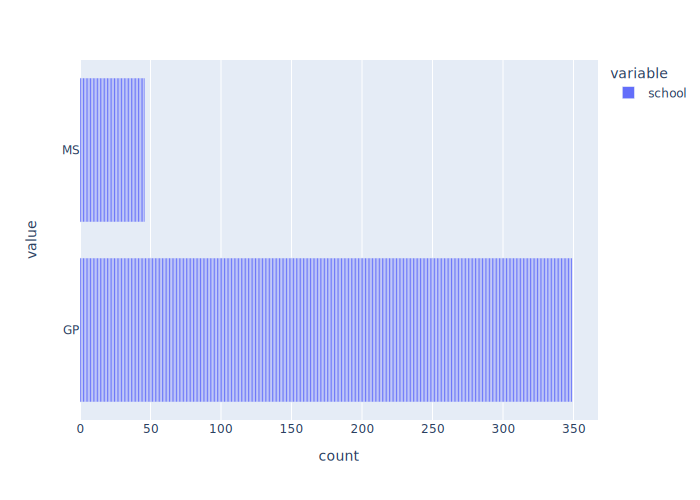

In [5]:
fig = px.bar(df, x=['school'])
fig.show('svg')

## sex

In [6]:
df.sex.describe()

count     395
unique      2
top         F
freq      208
Name: sex, dtype: object

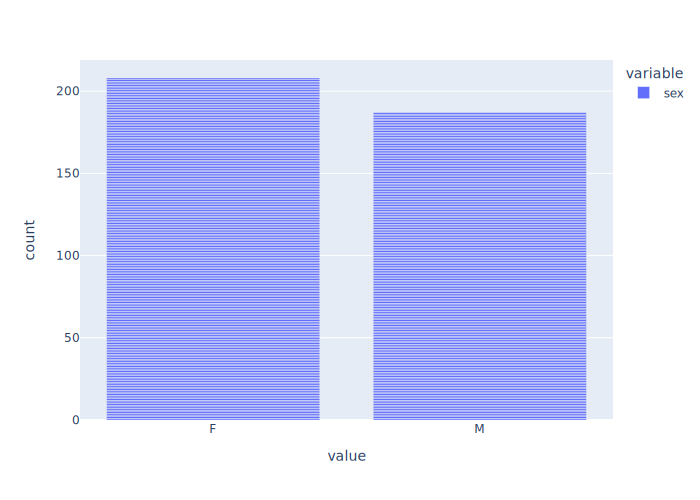

In [7]:
fig = px.bar(df, y=['sex'])
fig.show('svg')

## age

In [8]:
df.age.describe()

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

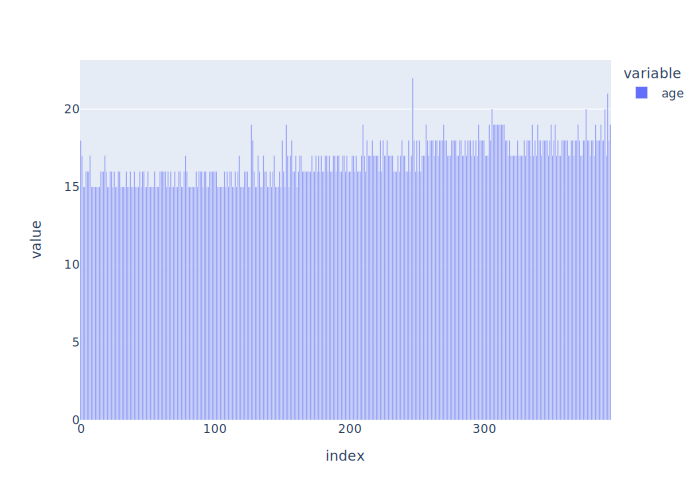

In [9]:
fig = px.bar(df, y=['age'])
fig.show('svg')

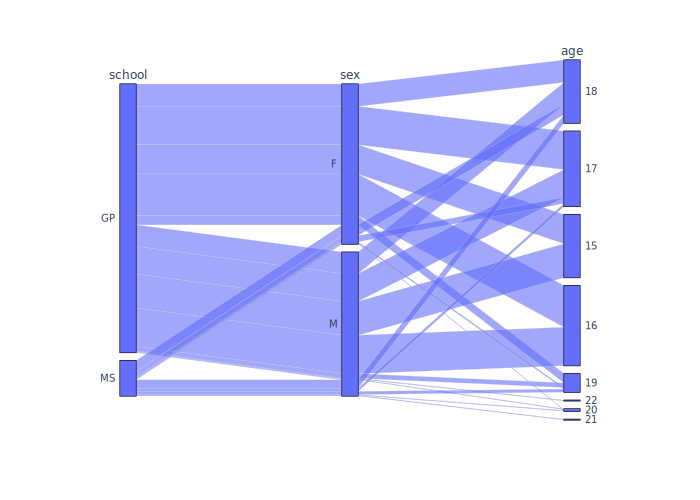

In [10]:
school_sex_age = px.parallel_categories(df, dimensions=['school', 'sex', 'age'],
                                        labels={'school': 'school', 'sex': 'sex', 'age': 'age'})
school_sex_age.show('svg')

## address

In [11]:
df.address.describe()

count     378
unique      2
top         U
freq      295
Name: address, dtype: object

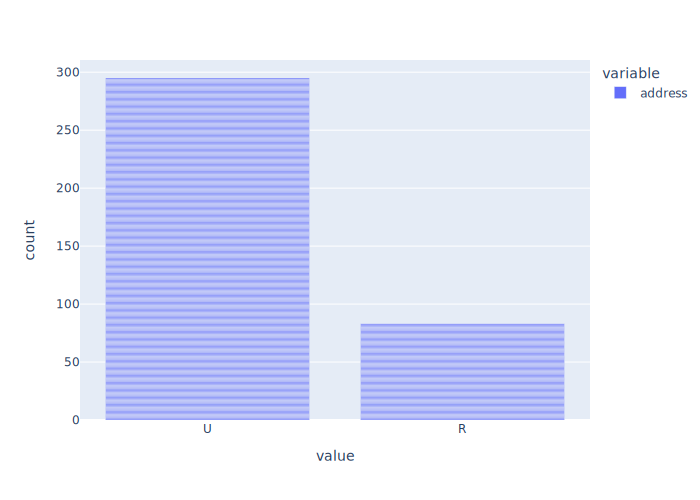

In [12]:
fig = px.bar(df, y=['address'])
fig.show('svg')

In [13]:
'''Заполним пропуски'''


def str_nan(col):
    return col.astype(str).apply(lambda x: None if x.strip() == '' else x)


df.address = str_nan(df.address)
df.address.describe()

count     395
unique      3
top         U
freq      295
Name: address, dtype: object

## famsize

In [14]:
df.famsize.describe()

count     368
unique      2
top       GT3
freq      261
Name: famsize, dtype: object

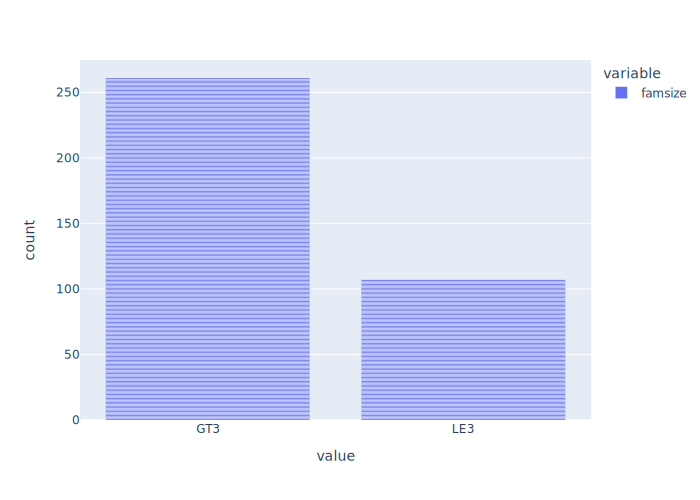

In [15]:
fig = px.bar(df, y=['famsize'])
fig.show('svg')

In [16]:
# также заменим пропуски на None
df.famsize = str_nan(df.famsize)
df.famsize.describe()

count     395
unique      3
top       GT3
freq      261
Name: famsize, dtype: object

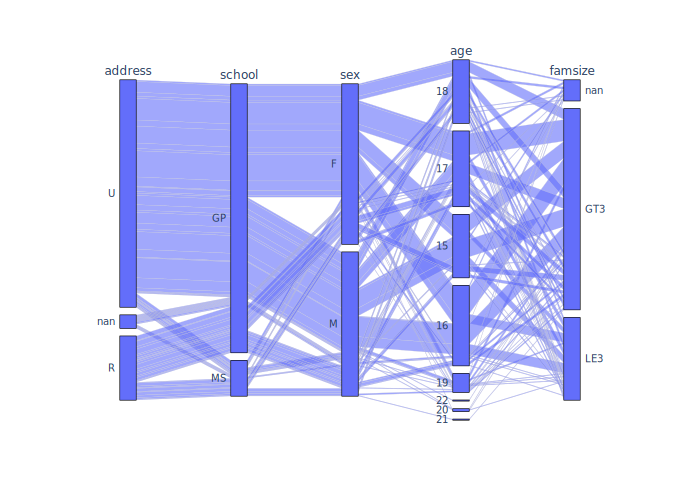

In [17]:
address_school_sex_age_famsize = px.parallel_categories(df, dimensions=['address', 'school', 'sex', 'age', 'famsize'],
                                                        labels={'address': 'address', 'school': 'school', 'sex': 'sex', 'age': 'age', 'famsize': 'famsize'})
address_school_sex_age_famsize.show('svg')

## Pstatus

In [18]:
df.Pstatus.describe()

count     350
unique      2
top         T
freq      314
Name: Pstatus, dtype: object

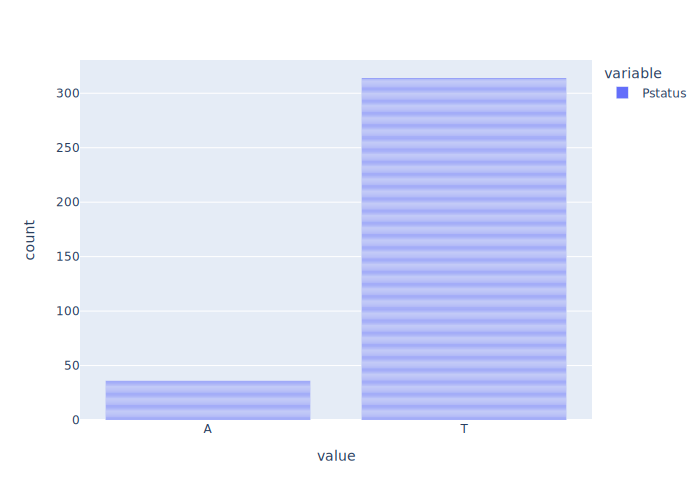

In [19]:
fig = px.bar(df, y=['Pstatus'])
fig.show('svg')

In [20]:
df.Pstatus = str_nan(df.Pstatus)
df.Pstatus.describe()

count     395
unique      3
top         T
freq      314
Name: Pstatus, dtype: object

Пропусков 11%, можем игнорировать - заменим на None. Однако, следует учитывать, что статус отношений родителей может умалчиваться более вероятно в случаях, когда родители живут раздельно, и респонденту не хочется говорить о личных сложностях

## Medu

In [21]:
df.Medu.describe()

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

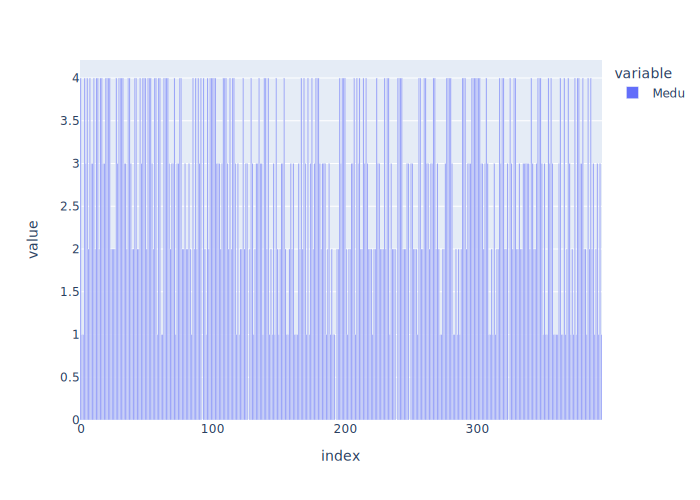

In [22]:
fig = px.bar(df, y=['Medu'])
fig.show('svg')

In [23]:
# заполним пропуски средним значением
df.Medu = df.Medu.fillna(round(df.Medu.median(), 1))
df.Medu.describe()

count    395.000000
mean       2.751899
std        1.094154
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

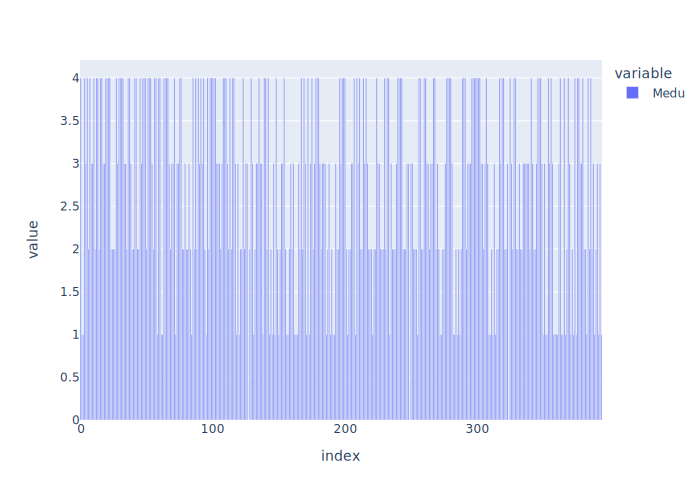

In [24]:
fig = px.bar(df, y=['Medu'])
fig.show('svg')

## Fedu

In [25]:
df.Fedu.describe()

count    371.000000
mean       2.614555
std        2.228732
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       40.000000
Name: Fedu, dtype: float64

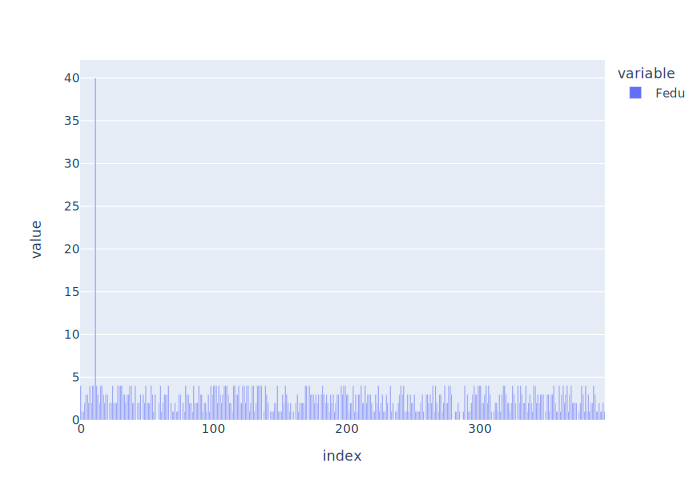

In [26]:
fig = px.bar(df, y=['Fedu'])
fig.show('svg')

Очевидно, что значения более 4.0 не соответствуют здравому смыслу и являются ошибкой в данных. Хотя похоже, что просто при заполнении лишний 0 к цифре 4 приписали. Тем более, что это всего одно такое значение. Так что уберем этот лишний 0 и заполним пропуски медианным значением

In [27]:
df[df.Fedu > 4]

school sex  age address famsize Pstatus  Medu  Fedu      Mjob   Fjob  \
11     GP   F   15       U     GT3     nan   2.0  40.0  services  other   

        reason guardian  traveltime  studytime  failures schoolsup famsup  \
11  reputation   father         3.0        3.0       0.0        no    yes   

   paid activities nursery  studytime, granular higher internet romantic  \
11   no        yes     yes                 -9.0    yes      yes       no   

    famrel  freetime  goout  health  absences  score  
11     5.0       2.0    2.0     4.0       4.0   60.0

count    395.000000
mean       2.486076
std        1.062362
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

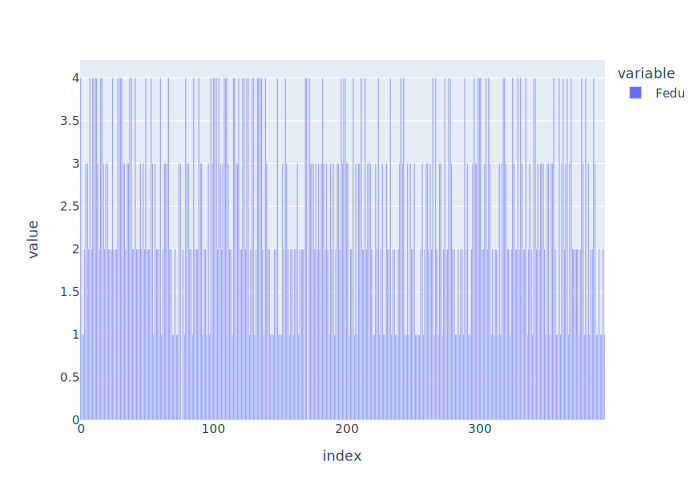

In [28]:
df.Fedu = df.Fedu.apply(lambda x: 4 if x > 4 else x)
df.Fedu = df.Fedu.fillna(round(df.Fedu.median(), 1))
display(df.Fedu.describe())
fig = px.bar(df, y=['Fedu'])
fig.show('svg')

## Mjob

In [29]:
df.Mjob.describe()

count       376
unique        5
top       other
freq        133
Name: Mjob, dtype: object

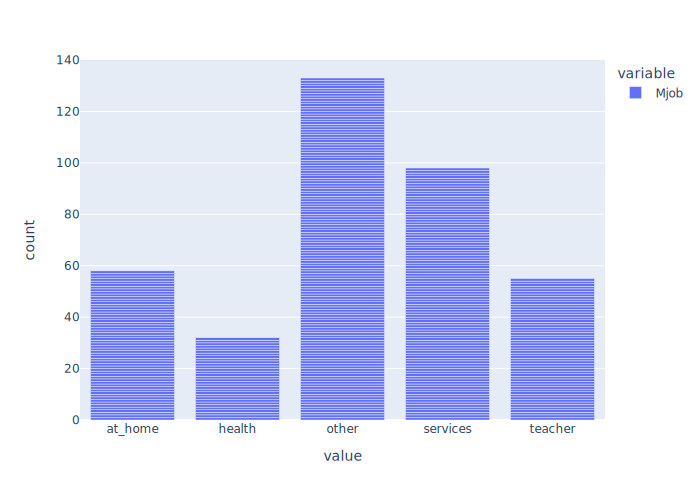

In [30]:
fig = px.bar(df, y=['Mjob'])
fig.show('svg')

In [31]:
# Заменим пропуски
df.Mjob = str_nan(df.Mjob)
df.Mjob.describe()

count       395
unique        6
top       other
freq        133
Name: Mjob, dtype: object

## Fjob

In [32]:
df.Fjob.describe()

count       359
unique        5
top       other
freq        197
Name: Fjob, dtype: object

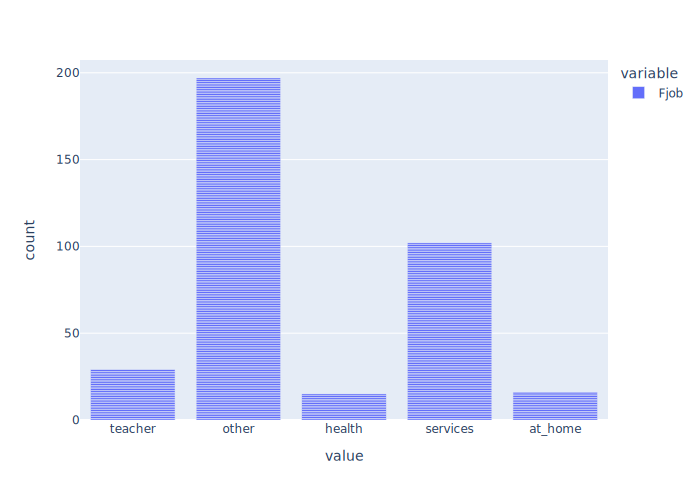

In [33]:
fig = px.bar(df, y=['Fjob'])
fig.show('svg')

In [34]:
# Заменим пропуски
df.Fjob = str_nan(df.Fjob)
df.Fjob.describe()

count       395
unique        6
top       other
freq        197
Name: Fjob, dtype: object

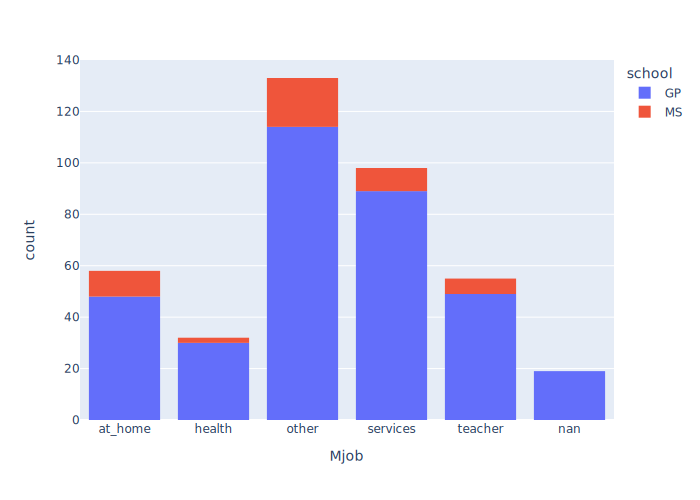

In [35]:
fig_mjob = px.histogram(df,
                        x="Mjob",
                        color="school")
fig_mjob.show('svg')

## reason

In [36]:
df.reason.describe()

count        378
unique         4
top       course
freq         137
Name: reason, dtype: object

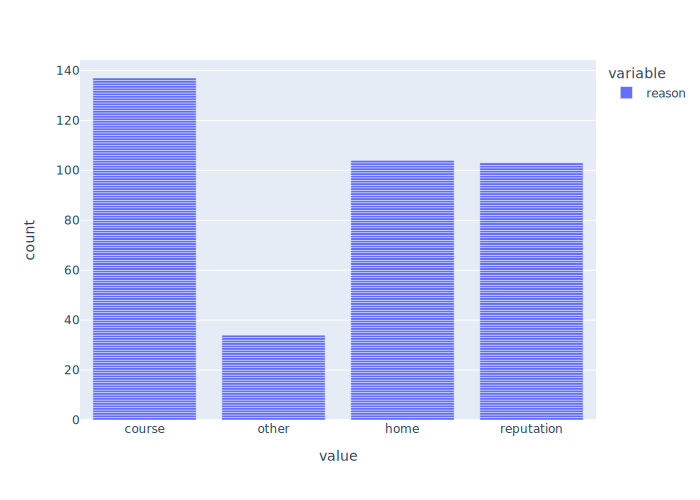

In [37]:
fig = px.bar(df, y=['reason'])
fig.show('svg')

count        395
unique         5
top       course
freq         137
Name: reason, dtype: object

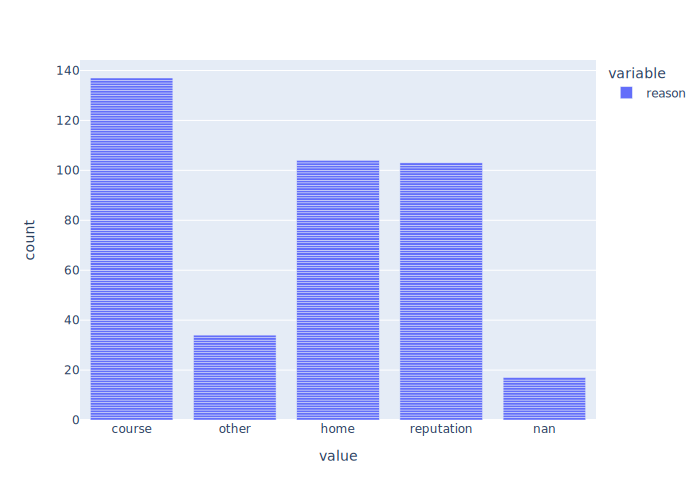

In [38]:
# заменим пропуски, выведем график
df.reason = str_nan(df.reason)
display(df.reason.describe())
fig = px.bar(df, y=['reason'])
fig.show('svg')

## guardian

In [39]:
df.guardian.describe()

count        364
unique         3
top       mother
freq         250
Name: guardian, dtype: object

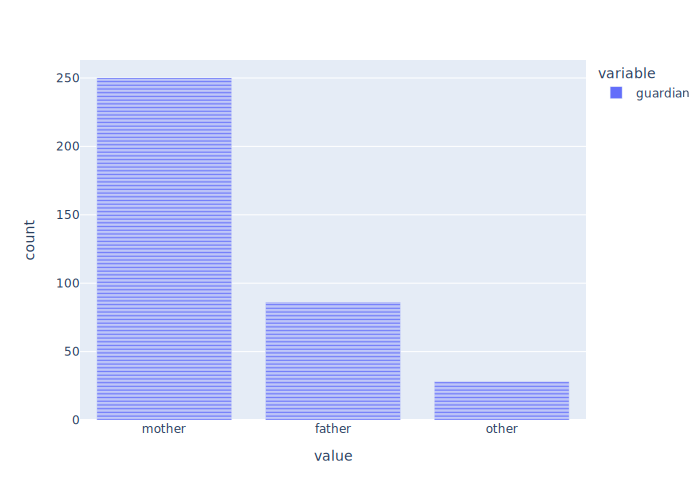

In [40]:
fig = px.bar(df, y=['guardian'])
fig.show('svg')

count        395
unique         4
top       mother
freq         250
Name: guardian, dtype: object

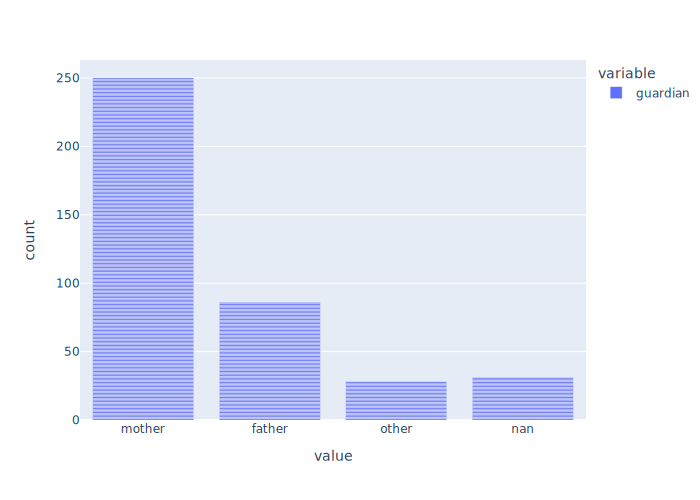

In [41]:
# заменим пропуски, выведем график
df.guardian = str_nan(df.guardian)
display(df.guardian.describe())
fig = px.bar(df, y=['guardian'])
fig.show('svg')

## traveltime

In [42]:
df.traveltime.describe()

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

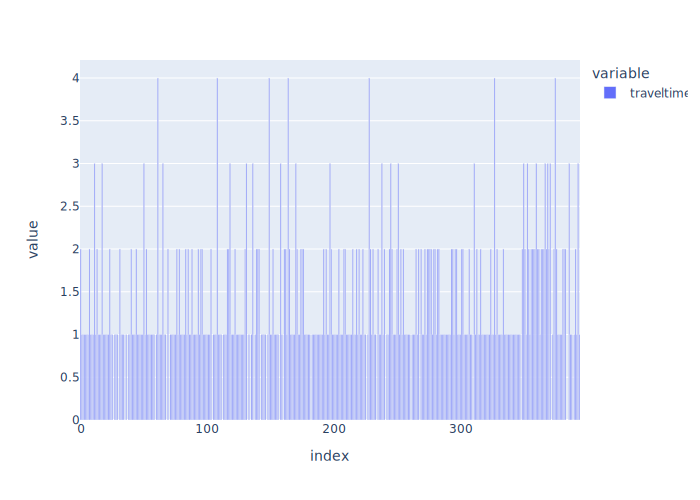

In [43]:
fig = px.bar(df, y=['traveltime'])
fig.show('svg')

count    395.000000
mean       1.407595
std        0.678490
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

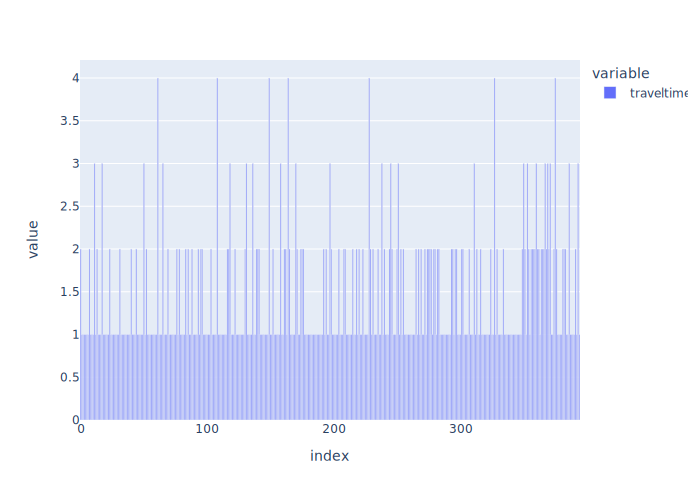

In [44]:
# заменим пропуски на медианное значение
df.traveltime = df.traveltime.fillna(round(df.traveltime.median(), 1))
display(df.traveltime.describe())
fig = px.bar(df, y=['traveltime'])
fig.show('svg')

## studytime

In [45]:
df.studytime.describe()

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

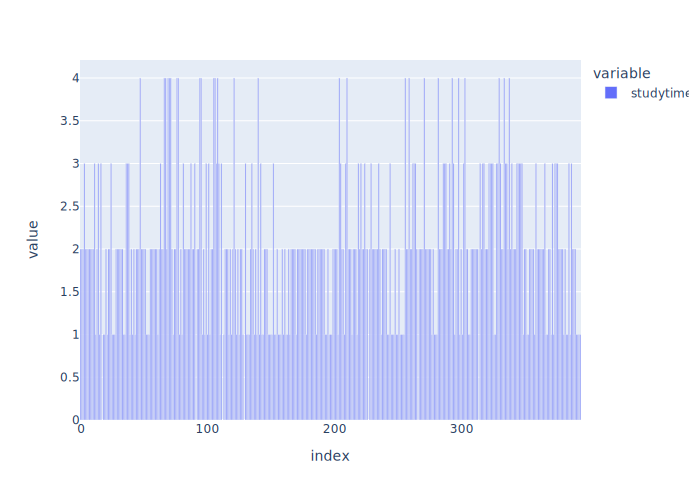

In [46]:
fig = px.bar(df, y=['studytime'])
fig.show('svg')

count    395.000000
mean       2.037975
std        0.834580
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

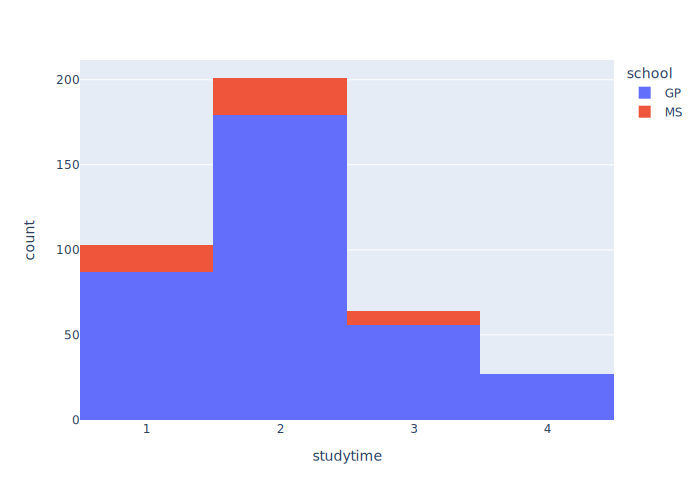

In [47]:
# заменим пропуски медианным значением
# посмотрим на графике распределение studytime по школам
df.studytime = df.studytime.fillna(round(df.studytime.median(), 1))
display(df.studytime.describe())

px.histogram(df, x="studytime", color="school").show('svg')

## failures

In [48]:
df.failures.describe()

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

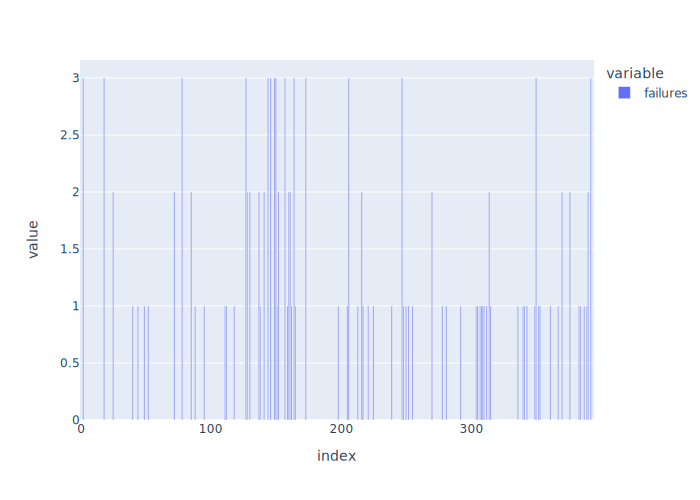

In [49]:
fig = px.bar(df, y=['failures'])
fig.show('svg')

count    395.000000
mean       0.318987
std        0.726244
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

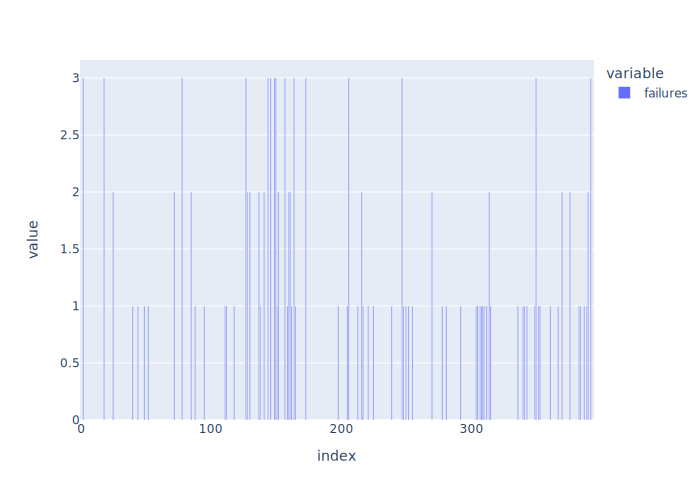

In [50]:
# Из условия под 0 у нас все значения кроме 1,2,3, заполним пропуски нулями
df.failures = df.failures.fillna(0)
display(df.failures.describe())
fig = px.bar(df, y=['failures'])
fig.show('svg')

## schoolsup

In [51]:
df.schoolsup.describe()

count     386
unique      2
top        no
freq      335
Name: schoolsup, dtype: object

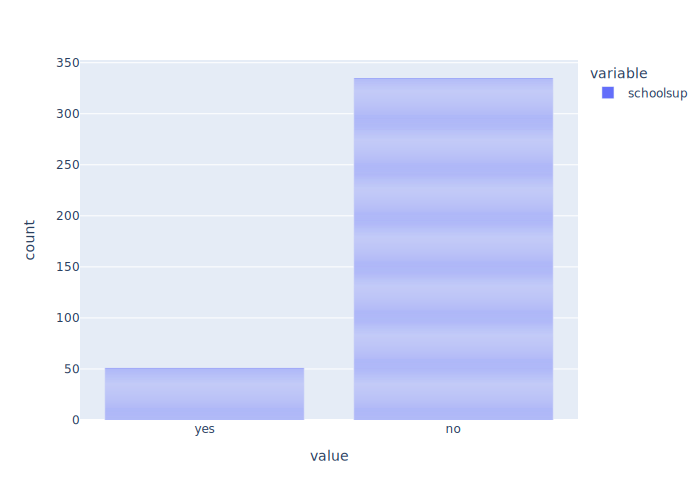

In [52]:
fig = px.bar(df, y=['schoolsup'])
fig.show('svg')

In [53]:
# Заполним пропуски
df.schoolsup = str_nan(df.schoolsup)
df.schoolsup.describe()

count     395
unique      3
top        no
freq      335
Name: schoolsup, dtype: object

## famsup

In [54]:
df.famsup.describe()

count     356
unique      2
top       yes
freq      219
Name: famsup, dtype: object

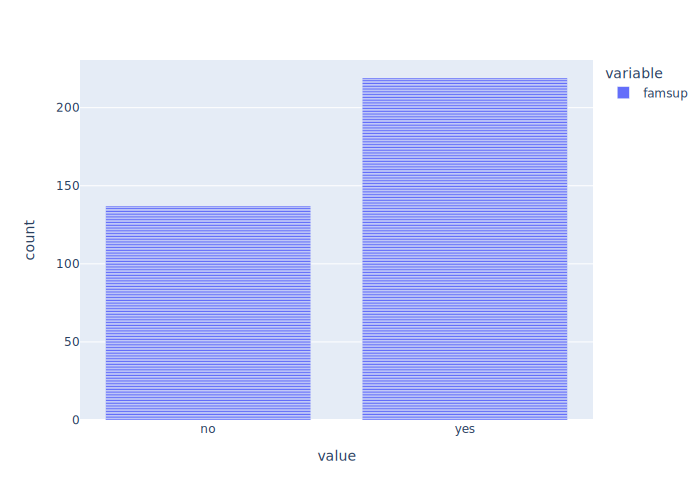

In [55]:
fig = px.bar(df, y=['famsup'])
fig.show('svg')

In [56]:
# Заполним пропуски
df.famsup = str_nan(df.famsup)
df.famsup.describe()

count     395
unique      3
top       yes
freq      219
Name: famsup, dtype: object

## paid

In [57]:
df.paid.describe()

count     355
unique      2
top        no
freq      200
Name: paid, dtype: object

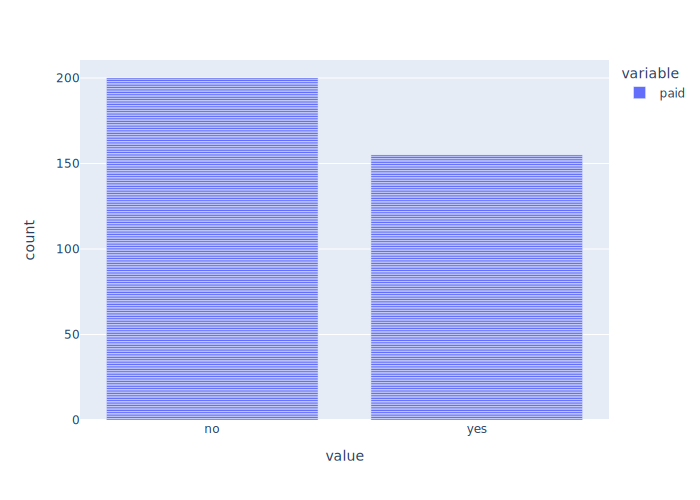

In [58]:
fig = px.bar(df, y=['paid'])
fig.show('svg')

In [59]:
# Заполним пропуски
df.paid = str_nan(df.paid)
df.paid.describe()

count     395
unique      3
top        no
freq      200
Name: paid, dtype: object

## activities

In [60]:
df.activities.describe()

count     381
unique      2
top       yes
freq      195
Name: activities, dtype: object

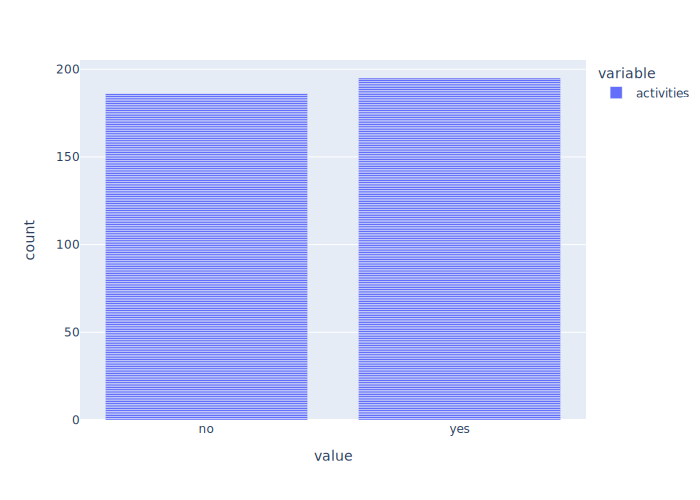

In [61]:
fig = px.bar(df, y=['activities'])
fig.show('svg')

In [62]:
# Заполним пропуски
df.activities = str_nan(df.activities)
df.activities.describe()

count     395
unique      3
top       yes
freq      195
Name: activities, dtype: object

## nursery

In [63]:
df.nursery.describe()

count     379
unique      2
top       yes
freq      300
Name: nursery, dtype: object

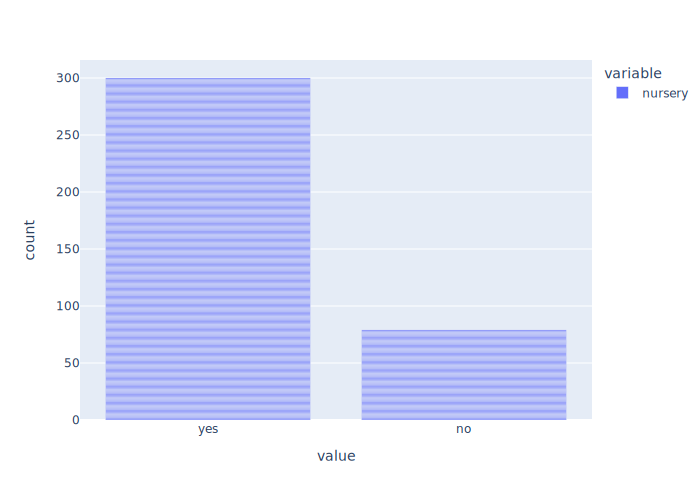

In [64]:
fig = px.bar(df, y=['nursery'])
fig.show('svg')

In [65]:
# Заполним пропуски
df.nursery = str_nan(df.nursery)
df.nursery.describe()

count     395
unique      3
top       yes
freq      300
Name: nursery, dtype: object

## studytime, granular

In [66]:
df['studytime, granular'].describe()

count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

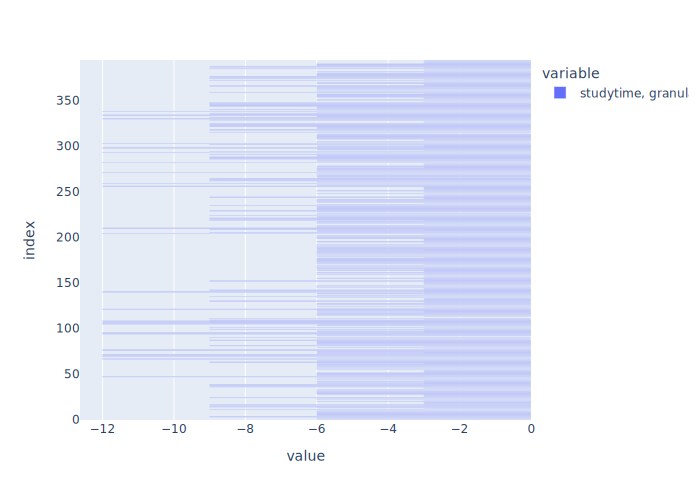

In [67]:
fig = px.bar(df, x=['studytime, granular'])
fig.show('svg')

In [68]:
df.drop(['studytime, granular'], inplace=True, axis=1)

## higher

Интересный параметр, очевидно, что студенты, которые не хотят получать высшее образование по каким либо причинам, вряд ли будут сильно стараться для госэкзамена

In [69]:
df.higher.describe()

count     375
unique      2
top       yes
freq      356
Name: higher, dtype: object

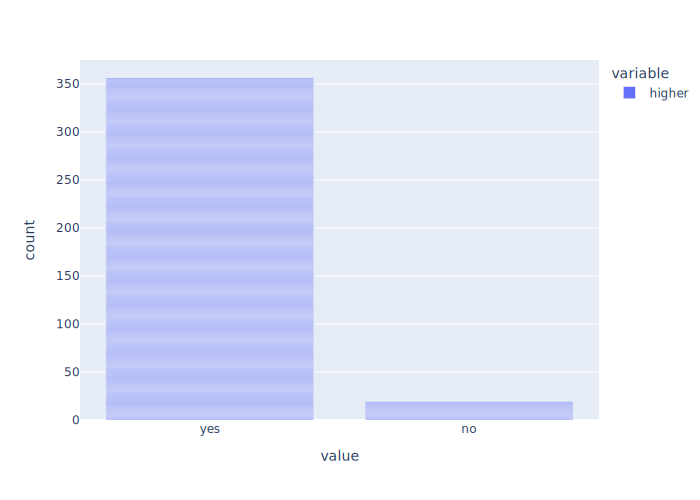

In [70]:
fig = px.bar(df, y=['higher'])
fig.show('svg')

In [71]:
# Заполним пропуски
df.higher = str_nan(df.higher)
df.higher.describe()

count     395
unique      3
top       yes
freq      356
Name: higher, dtype: object

## internet

In [72]:
df.internet.describe()

count     361
unique      2
top       yes
freq      305
Name: internet, dtype: object

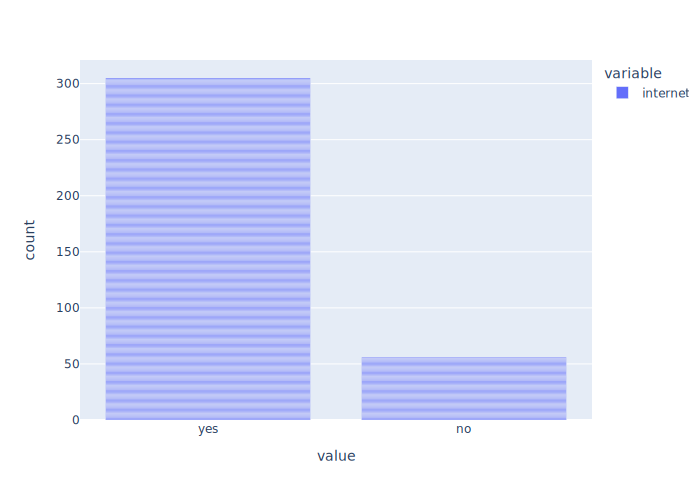

In [73]:
fig = px.bar(df, y=['internet'])
fig.show('svg')

In [74]:
# Заполним пропуски
df.internet = str_nan(df.internet)
df.internet.describe()

count     395
unique      3
top       yes
freq      305
Name: internet, dtype: object

## romantic

In [75]:
df.romantic.describe()

count     364
unique      2
top        no
freq      240
Name: romantic, dtype: object

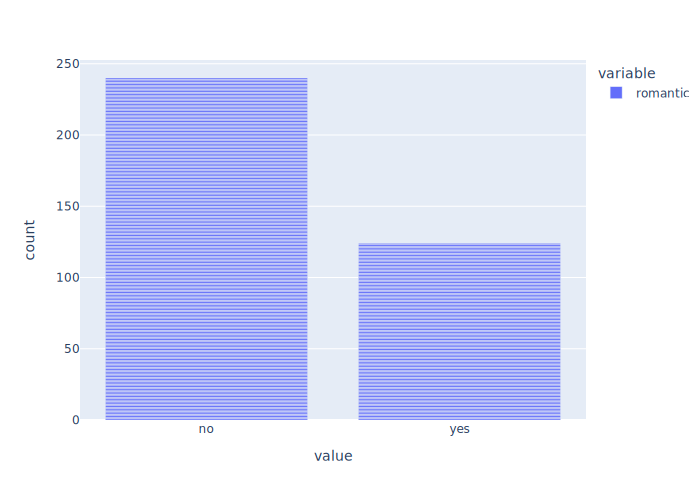

In [76]:
fig = px.bar(df, y=['romantic'])
fig.show('svg')

In [77]:
# Заполним пропуски
df.romantic = str_nan(df.romantic)
df.romantic.describe()

count     395
unique      3
top        no
freq      240
Name: romantic, dtype: object

## famrel

In [78]:
df.famrel.describe()

count    368.000000
mean       3.937500
std        0.927277
min       -1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

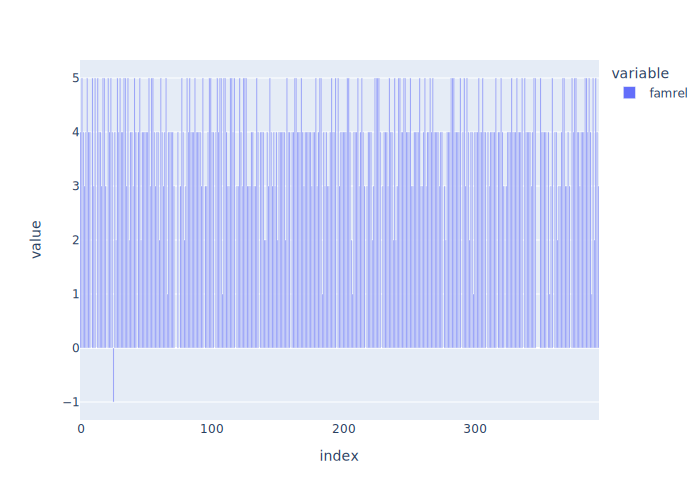

In [79]:
fig = px.bar(df, y=['famrel'])
fig.show('svg')

In [80]:
df[df.famrel < 1]

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
25     GP   F   16       U     GT3     nan   2.0   2.0  services  services   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
25   home   mother         1.0        1.0       2.0        no    yes  yes   

   activities nursery higher internet romantic  famrel  freetime  goout  \
25         no      no    yes      yes       no    -1.0       2.0    2.0   

    health  absences  score  
25     5.0      14.0   40.0

Очевидно, что значение -1 не соответсвует здравому смыслу и является ошибкой в заполнении данных, можем приедположить, что знак '-' перед единицей ввели случайно при заполнении. Так что уберем этот лишний минус и заполним пропуски медианным значением

count    395.000000
mean       3.946835
std        0.872425
min        1.000000
25%        4.000000
50%        4.000000
75%        4.500000
max        5.000000
Name: famrel, dtype: float64

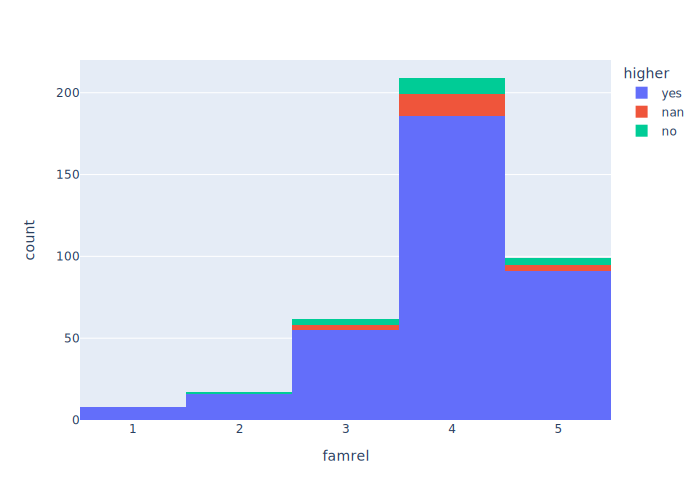

In [81]:
df.famrel = df.famrel.apply(lambda x: abs(x) if x < 0 else x)
df.famrel = df.famrel.fillna(round(df.famrel.median(), 1))
display(df.famrel.describe(include='all'))
px.histogram(df, x="famrel", color="higher").show('svg')

## freetime

In [82]:
df.freetime.describe()

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

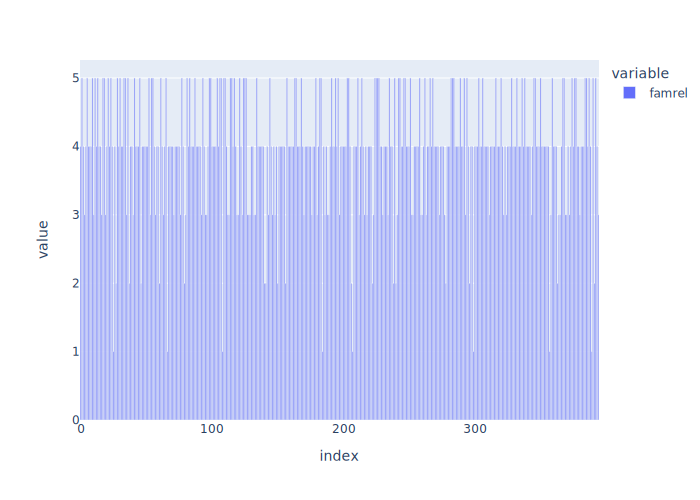

In [83]:
fig = px.bar(df, y=['famrel'])
fig.show('svg')

count    395.000000
mean       3.225316
std        0.980711
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

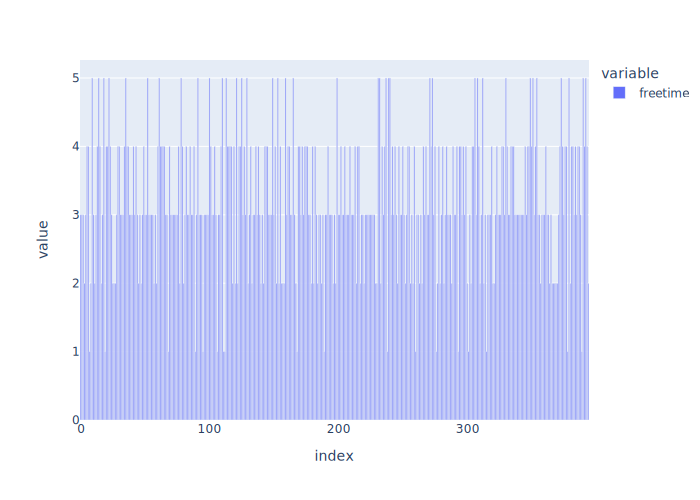

In [84]:
# заполеним пропуски медианным значением
df.freetime = df.freetime.fillna(round(df.freetime.median(), 1))
display(df.freetime.describe())
fig = px.bar(df, y=['freetime'])
fig.show('svg')

## goout

In [85]:
df.goout.describe()

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

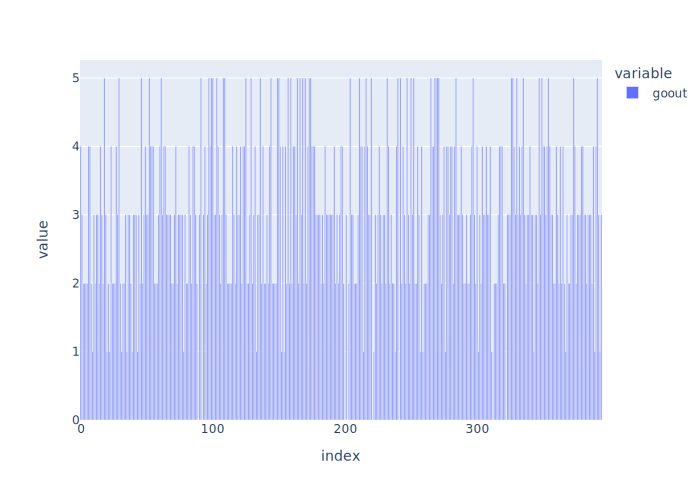

In [86]:
fig = px.bar(df, y=['goout'])
fig.show('svg')

count    395.000000
mean       3.103797
std        1.104610
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

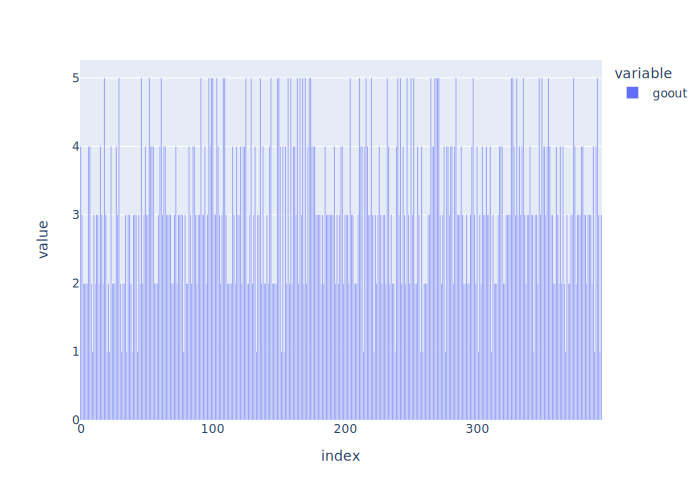

In [87]:
# заполним пропущенные значения медианным
df.goout = df.goout.fillna(round(df.goout.median(), 1))
display(df.goout.describe())
fig = px.bar(df, y=['goout'])
fig.show('svg')

## health

In [88]:
df.health.describe()

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

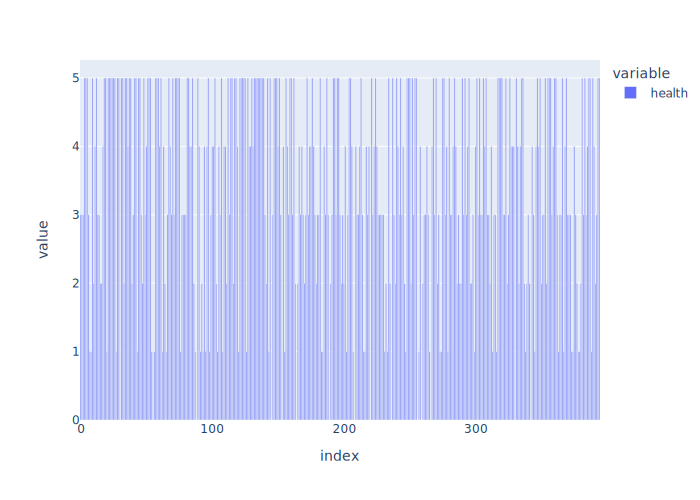

In [89]:
fig = px.bar(df, y=['health'])
fig.show('svg')

count    395.000000
mean       3.549367
std        1.372118
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

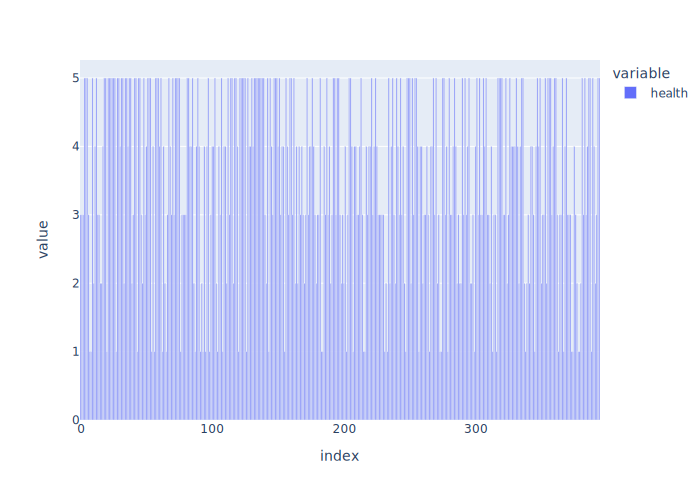

In [90]:
# также заполним пропуски медианным значением
df.health = df.health.fillna(round(df.health.median(), 1))
display(df.health.describe())
fig = px.bar(df, y=['health'])
fig.show('svg')

## absences

In [91]:
df.absences.describe()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

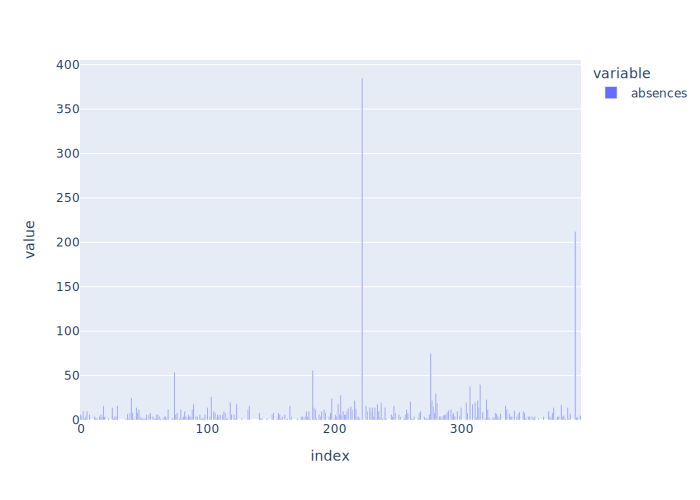

In [92]:
fig = px.bar(df, y=['absences'])
fig.show('svg')

у нас есть выброс - студент с 385 пропусков и при этом с высоким баллом по экзамену, здоровье у этой девочки на 3, может это причина большого количества пропусков. Есть еще мальчик 212 пропусков, его баллы вроде средние. Это может сильно исказить нормальное распределение. Проверим на выбросы:

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


count    366.000000
mean       4.603825
std        4.965512
min        0.000000
25%        0.000000
50%        4.000000
75%        7.000000
max       20.000000
Name: absences, dtype: float64

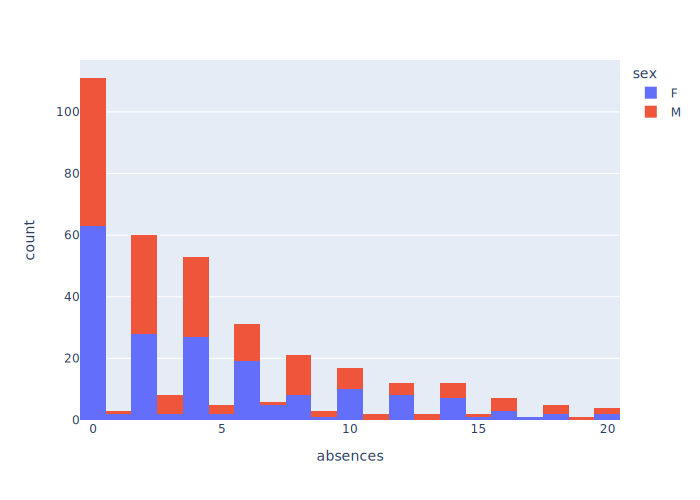

In [93]:
IQR = df.absences.quantile(0.75) - df.absences.quantile(0.25)
perc25 = df.absences.quantile(0.25)
perc75 = df.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
display(df.absences.loc[df.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)].describe())
px.histogram(df[df.absences.between(perc25 - 1.5*IQR, perc75 +
             1.5*IQR)], x="absences", color="sex").show('svg')

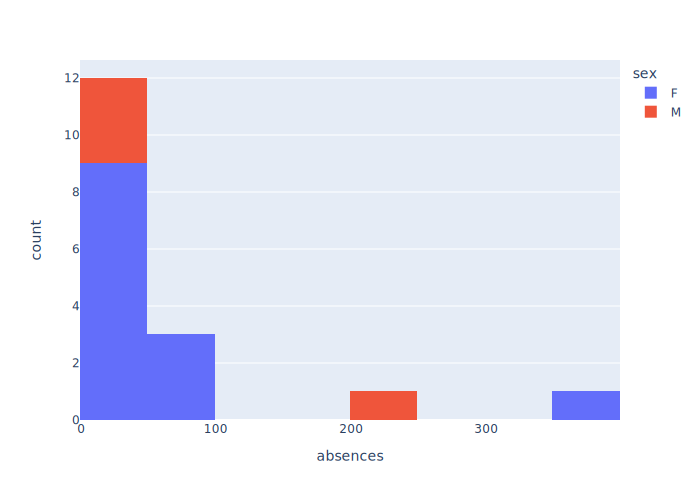

In [94]:
px.histogram(df[~df.absences.between(perc25 - 1.5*IQR,
             perc75 + 1.5*IQR)], x="absences", color="sex").show('svg')

Чтож, мы отобрали экстремально высокие данные. С одной стороны, экстремально высокие значения пропусков - это явный сигнал, что студент в группе риска, заставляет задуматься, почему он пропускает уроки и они важны для будущей модели, но могут сильно исказить среднюю картину. Вообще, у нас всего то 2 суперэкстремальных значения - 212 и 385. Если мы используем формулу с квантилями мы теряем слишком много значений от 20 до 100 пропусков. Так что пока просто отфильтруем значения менее 100 пропусков и заполним пропуски в данных медианным значением. 

count    393.000000
mean       5.697201
std        7.969484
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64

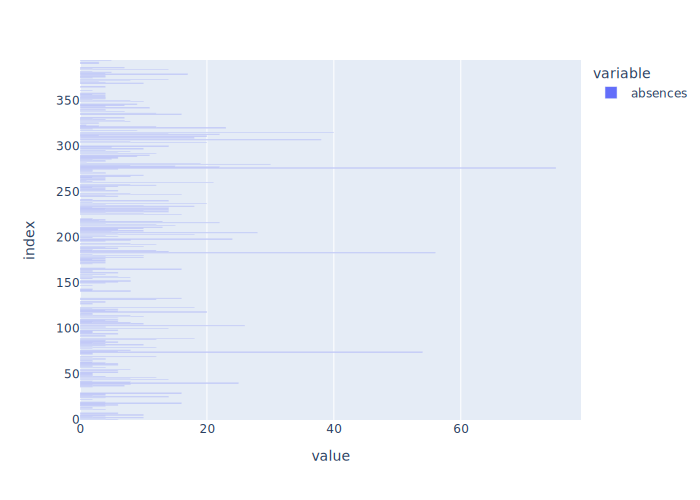

In [95]:
df.absences = df.absences.fillna(round(df.absences.median(), 1))
df = df[df.absences < 100]
display(df.absences.describe())
fig = px.bar(df, x=['absences'])
fig.show('svg')

## score

* score - важный параметр, так как именно его должна научиться предсказывать будущая модель

In [96]:
df.score.describe()

count    387.000000
mean      52.196382
std       22.914748
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

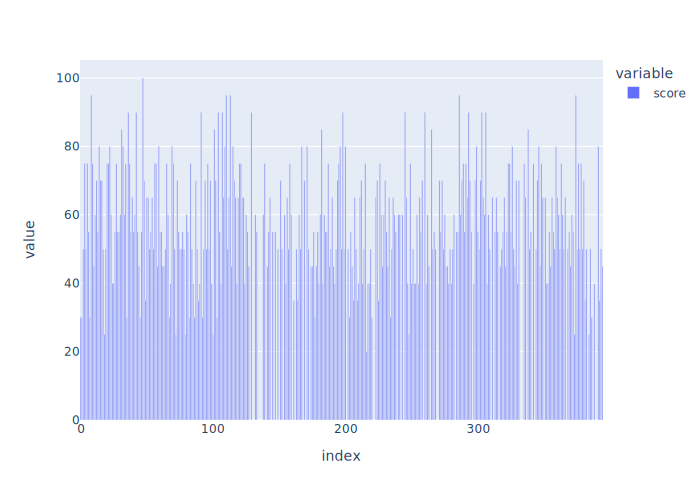

In [97]:
fig = px.bar(df, y=['score'])
fig.show('svg')

In [98]:
df[df.score.isnull()]

school sex  age address famsize Pstatus  Medu  Fedu   Mjob      Fjob  \
201     GP   F   16       U     GT3       T   2.0   3.0  other     other   
244     GP   F   18       U     GT3       T   2.0   1.0  other     other   
270     GP   F   19     nan     GT3       T   3.0   3.0  other  services   
283     GP   F   18       U     GT3       T   1.0   1.0  other     other   
312     GP   M   19       U     GT3       T   1.0   2.0  other  services   
350     MS   M   19     nan     GT3       T   1.0   1.0  other  services   

         reason guardian  traveltime  studytime  failures schoolsup famsup  \
201  reputation   mother         1.0        2.0       0.0       yes    yes   
244      course    other         2.0        3.0       0.0        no    yes   
270        home    other         1.0        2.0       2.0        no    yes   
283        home   mother         2.0        2.0       0.0       yes    nan   
312      course    other         1.0        2.0       1.0        no     no   
350        home    other         3.0        2.0       3.0        no     no   

    paid activities nursery higher internet romantic  famrel  freetime  goout  \
201  nan        yes     yes    yes       no       no     4.0       3.0    3.0   
244  yes         no      no    yes      yes      yes     4.0       4.0    4.0   
270  yes        yes     yes    yes      yes       no     4.0       3.0    5.0   
283   no        yes     yes    yes      yes       no     5.0       3.0    4.0   
312   no         no      no    yes      yes       no     4.0       5.0    3.0   
350   no         no     nan    yes      yes       no     5.0       4.0    4.0   

     health  absences  score  
201     4.0       6.0    NaN  
244     3.0       0.0    NaN  
270     5.0       4.0    NaN  
283     4.0       4.0    NaN  
312     4.0       3.0    NaN  
350     2.0       8.0    NaN

In [99]:
# заполним пропуски медианным значением
df.score = df.score.fillna(round(df.score.median(), 1))
df.describe(include='all')
df.score.iplot(kind='hist')

# Корреляционный анализ


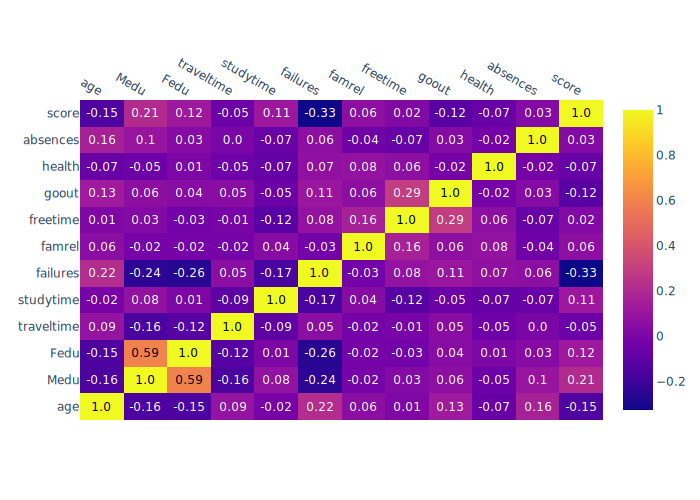

In [100]:
corrs = df.corr()

figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

figure.show('svg')

#### Итак, мы видим положительную корреляцию со значением score: 
* absences - вообще, это странно, что больше пропусков=лучше балл, возможно, более умные студенты позволяют себе чаще пропускать уроки? тем более, что корреляция слабенькая
* freetime - чем больше свободного времени, тем лучше баллы на экзамене. Очевидно, что наличие свободного времени способствует нормальному психологическому состоянию и позволяет быть успешнее
* famrel - чем лучше отношения в семье, тем успешнее студент. Тут логично)
* studytime - чем больше дополнительного времени на учебу, тем лучше результат
* Fedu - образование отца. Логично, что у умных родителей и дети умнее
* Medu - образование матери. Интересно, что тут коэффициент корреляции гораздо выше чем у отца. Мама с хорошим образованием, видимо, отлично мотивирует своего ребенка
#### Также мы видим отрицательную корреляцию:
* health - интересно. Видимо, более физически здоровые студенты занимаются чем то кроме математики
* goout - чем больше времени студент проводит с друзьями, тем меньше остается на учебу
* failures - тут довольно сильная корреляция, количество внеучебных неудач довольно сильно снижает успеваемость
* traveltime - чем больше времени студент тратит на путь до школы, тем, видимо, у него меньше потом мотивации учиться
* age - можно предположить, что чем старше студент, тем более сложный у него учебный материал и естесственно, больше студентов начинают отставать


# Анализ номинативных переменных

### Номинативные переменные, которые осталось рассмотреть:  
'school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'
* итого - 17 номинативных переменных

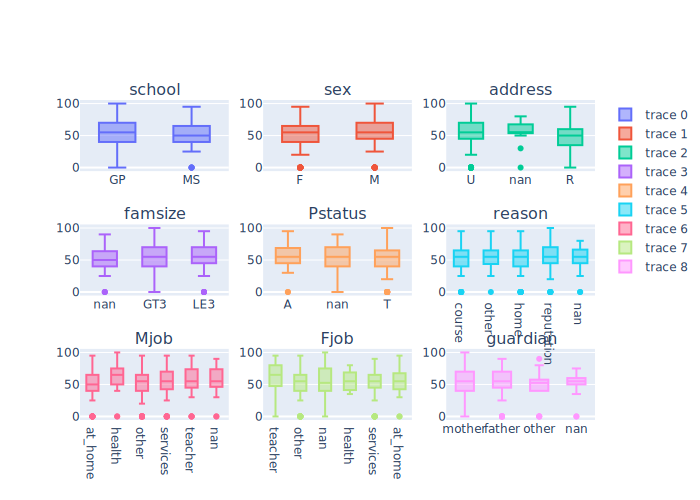

In [101]:
fig = make_subplots(rows=3, cols=3, subplot_titles=(
    'school', 'sex', 'address', 'famsize', 'Pstatus', 'reason', 'Mjob', 'Fjob', 'guardian'))
fig.add_trace(go.Box(x=df['school'], y=df['score']), row=1, col=1)
fig.add_trace(go.Box(x=df['sex'], y=df['score']), row=1, col=2)
fig.add_trace(go.Box(x=df['address'], y=df['score']), row=1, col=3)
fig.add_trace(go.Box(x=df['famsize'], y=df['score']), row=2, col=1)
fig.add_trace(go.Box(x=df['Pstatus'], y=df['score']), row=2, col=2)
fig.add_trace(go.Box(x=df['reason'], y=df['score']), row=2, col=3)
fig.add_trace(go.Box(x=df['Mjob'], y=df['score']), row=3, col=1)
fig.add_trace(go.Box(x=df['Fjob'], y=df['score']), row=3, col=2)
fig.add_trace(go.Box(x=df['guardian'], y=df['score']), row=3, col=3)

fig.show('svg')

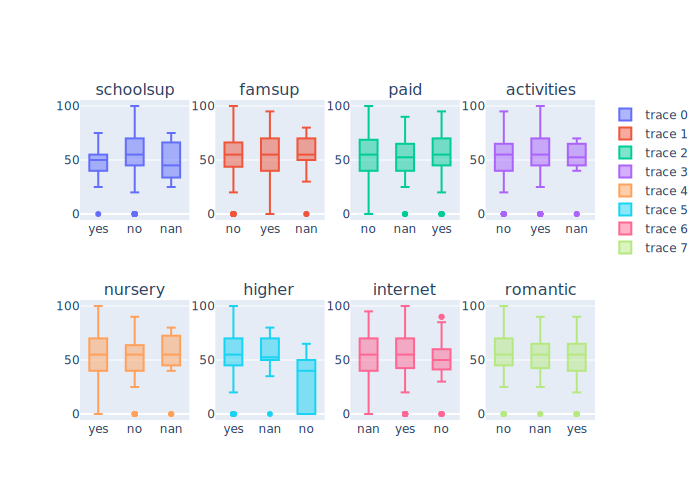

In [102]:
fig = make_subplots(rows=2, cols=4, subplot_titles=(
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'))
fig.add_trace(go.Box(x=df['schoolsup'], y=df['score']), row=1, col=1)
fig.add_trace(go.Box(x=df['famsup'], y=df['score']), row=1, col=2)
fig.add_trace(go.Box(x=df['paid'], y=df['score']), row=1, col=3)
fig.add_trace(go.Box(x=df['activities'], y=df['score']), row=1, col=4)
fig.add_trace(go.Box(x=df['nursery'], y=df['score']), row=2, col=1)
fig.add_trace(go.Box(x=df['higher'], y=df['score']), row=2, col=2)
fig.add_trace(go.Box(x=df['internet'], y=df['score']), row=2, col=3)
fig.add_trace(go.Box(x=df['romantic'], y=df['score']), row=2, col=4)

fig.show('svg')

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, с помощью теста Стьюдента. Проверим нулевую гипотезу о том, что распределения баллов  по различным параметрам неразличимы:

In [103]:
def get_stat_dif(column):
    cols = df.loc[:, column].value_counts()
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'],
                     df.loc[df.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
        print('Не найдены статистически значимые различия для колонки', column)

In [104]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col)

Не найдены статистически значимые различия для колонки school
Не найдены статистически значимые различия для колонки sex
Не найдены статистически значимые различия для колонки address
Не найдены статистически значимые различия для колонки address
Не найдены статистически значимые различия для колонки address
Не найдены статистически значимые различия для колонки famsize
Не найдены статистически значимые различия для колонки famsize
Не найдены статистически значимые различия для колонки famsize
Не найдены статистически значимые различия для колонки Pstatus
Не найдены статистически значимые различия для колонки Pstatus
Не найдены статистически значимые различия для колонки Pstatus
Не найдены статистически значимые различия для колонки Mjob
Не найдены статистически значимые различия для колонки Mjob
Не найдены статистически значимые различия для колонки Mjob
Не найдены статистически значимые различия для колонки Mjob
Не найдены статистически значимые различия для колонки Mjob
Не найдены с

### Итак, ни одна из номинативных переменных не представляет интереса для построения модели.
##### В нашем случае важные переменные, которые, возможно, оказывают влияние на баллы за экзамен, это:    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences'
Оставим их для дальнейшего построения модели

In [105]:
df_for_model = df.loc[:, ['age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                          'failures', 'famrel', 'freetime', 'goout', 'health', 'absences']]
df_for_model.head()

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18   4.0   4.0         2.0        2.0       0.0     4.0       3.0    4.0   
1   17   1.0   1.0         1.0        2.0       0.0     5.0       3.0    3.0   
2   15   1.0   1.0         1.0        2.0       3.0     4.0       3.0    2.0   
3   15   4.0   2.0         1.0        3.0       0.0     3.0       2.0    2.0   
4   16   3.0   3.0         1.0        2.0       0.0     4.0       3.0    2.0   

   health  absences  
0     3.0       6.0  
1     3.0       4.0  
2     3.0      10.0  
3     5.0       2.0  
4     5.0       4.0

# Выводы

**Итак, в результате EDA для анализа влияния условий жизни школьников на успеваемость по математике были получены следующие выводы:**

    1. Нет пустых значений только в колонках 'school', 'sex', 'age'
    2. В остальных колонках пропусков до 10%, в строковых типах мы заполнили пропуски значением None, в количественных переменных заполнили пропуски медианным значением, в колонке failures заполнили пропуски нулями в соответсвии с условием
    3. Выбросы найдены в столбцах Fedu, famrel, absences, данные достаточно чистые
    4. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели:          
   **параметры с положительной корреляцией**
   
    * absences -  возможно, более умные студенты позволяют себе чаще пропускать уроки? 
    * freetime - чем больше свободного времени, тем лучше баллы на экзамене. Очевидно, что наличие свободного времени способствует нормальному психологическому состоянию и позволяет быть успешнее
    * famrel - чем лучше отношения в семье, тем успешнее студент. Тут логично)
    * studytime - чем больше дополнительного времени на учебу, тем лучше результат
    * Fedu - образование отца. Логично, что у умных родителей и дети умнее
    * Medu - образование матери. Интересно, что тут коэффициент корреляции гораздо выше чем у отца. Мама с хорошим образованием, видимо, отлично мотивирует своего ребенка    
   **параметры с отрицательной корреляцией:**
    
    * health - похоже, что более физически здоровые студенты занимаются чем то кроме математики
    * goout - чем больше времени студент проводит с друзьями, тем меньше остается на учебу
    * failures - тут довольно сильная корреляция, количество внеучебных неудач довольно сильно снижает успеваемость
    * traveltime - чем больше времени студент тратит на путь до школы, тем, видимо, у него меньше потом мотивации учиться
    * age - можно предположить, что чем старше студент, тем более сложный у него учебный материал и естесственно, больше студентов начинают отставать